In [19]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [20]:
import itertools
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import torchvision
import torch.optim as optim
from torchvision import datasets, transforms
from pgd_attack import pgd_attack, margin_loss, TransferPGD
from models import ResNet18, WideResNet28, ResNet34, WideResNet34
from tqdm import tqdm, trange
from model import get_model_for_attack

from attack_main import eval_model_pgd, eval_model_with_attack
from utils import prepare_cifar, Logger, check_mkdir
from eval_model import eval_model, eval_model_pgd

In [3]:
import matplotlib.pyplot as plt

In [4]:
torch.manual_seed(0)

In [5]:
def get_train_data():
    trainset_org = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True,
        transform=transforms.ToTensor()
    )
    loader_org = torch.utils.data.DataLoader(trainset_org, 10)
    return itertools.chain(loader_org)

In [6]:
dataset = get_train_data()

Files already downloaded and verified


In [7]:
model = WideResNet34()
model.load_state_dict(torch.load('logs/Jun08-2018_WideResNet34/WideResNet34_e49_0.8695_0.5897-final.pt'))
model.eval()

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (convShortcut): Conv2d(16, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNor

In [8]:
modeln = get_model_for_attack('model1')

In [33]:
eg = None
egy = None
for x, y in dataset:
    eg = x.squeeze()
    egy = y
    break

In [43]:
egy.shape

torch.Size([10])

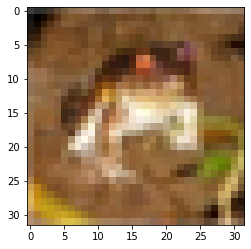

In [10]:
plt.imshow(eg[0].permute((1,2,0)))

true val:  tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3])
predict raw tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3])
pred:  tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3]) logit:  tensor([[-1.8667e+00, -2.1147e+00, -5.7386e-01,  3.3407e-01, -7.2054e-01,
          8.9453e-01,  1.0400e+01, -1.6685e+00, -2.0821e+00, -2.6025e+00],
        [-3.7131e-01, -1.4491e+00, -4.7163e-01, -1.1205e+00, -2.5388e+00,
         -7.3930e-01, -9.8749e-01, -8.2871e-01, -5.6092e-01,  9.0673e+00],
        [ 5.1351e-01, -7.6211e-01, -1.1317e-01, -1.4085e+00, -2.2026e+00,
         -1.0306e+00, -1.5986e+00, -1.3286e+00, -3.7237e-01,  8.3028e+00],
        [-6.5534e-01, -3.5632e+00, -1.3341e+00, -8.7812e-01,  1.2075e+01,
          1.1157e+00, -7.5690e-01, -1.0039e+00, -2.1652e+00, -2.8336e+00],
        [ 5.3409e-01,  8.3340e+00, -2.0738e+00, -1.4197e+00, -2.2835e+00,
         -6.1636e-01, -7.6221e-01, -1.9080e+00,  1.0275e-01,  9.2537e-02],
        [-9.9643e-01,  7.6967e+00, -2.2573e+00,  1.0367e+00, -2.0909e+00,
          5.4854e-01, -1.6

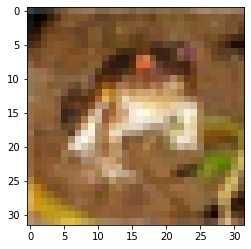

In [11]:
print("true val: ", egy)
print('predict raw', torch.argmax(modeln(eg),dim=1) )
for i in range(1):
    x_adv = eg + 0.01 * torch.randn(eg.shape).detach()
    x_adv = torch.clamp(x_adv, 0.0, 1.0)
    plt.imshow(x_adv[0].permute(1,2,0))
    logits = modeln(x_adv) 
    print('pred: ', torch.argmax(logits, dim=1), 'logit: ', logits)

true val:  tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3])
predict raw tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3])
pred:  tensor([4, 2, 2, 6, 0, 3, 5, 4, 0, 0]) logit:  tensor([[-2.6092e+00, -4.3337e+00, -1.1602e+00, -8.0152e-01,  1.7820e+01,
          9.5905e-01, -2.6019e+00, -1.3768e-01, -3.2022e+00, -3.9329e+00],
        [-1.9051e+00, -4.3866e+00,  1.9316e+01, -1.0385e+00, -1.0507e+00,
         -1.6870e+00, -1.3209e+00, -1.6168e+00, -2.7793e+00, -3.5316e+00],
        [-2.5956e+00, -5.3583e+00,  1.8019e+01, -4.1476e-01, -2.8706e+00,
         -1.9985e+00,  5.3164e-01, -3.3242e+00,  1.5936e+00, -3.5825e+00],
        [-3.0861e+00, -1.4737e+00, -6.9177e-01, -2.5567e+00, -3.0813e+00,
         -1.1448e+00,  1.8994e+01, -1.6600e+00, -2.1352e+00, -3.1650e+00],
        [ 1.7952e+01, -4.1044e+00, -4.3892e+00, -4.6863e+00,  1.2457e-01,
         -2.4373e+00, -3.6468e+00, -4.0700e-01,  1.8326e+00, -2.3851e-01],
        [-2.5058e+00, -3.1367e+00, -4.6603e-01,  1.5020e+01, -3.4359e-01,
          2.8907e-01, -1.8

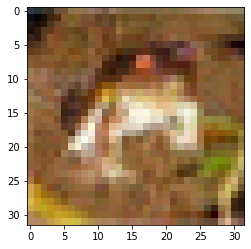

In [12]:
print("true val: ", egy)
print('predict raw', torch.argmax(modeln(eg),dim=1) )
for i in range(1):
    x_adv = pgd_attack(modeln, eg.clone(), egy.clone(), step_size=0.01, epsilon=8.0/255, perturb_steps=20)
    plt.imshow(x_adv[0].permute(1,2,0))
    logits = modeln(x_adv) 
    print('pred: ', torch.argmax(logits, dim=1), 'logit: ', logits)

## Robust Model

true val:  tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3])
predict raw tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3])
pred:  tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3]) logit:  tensor([[-1.5088, -2.4110,  0.5375,  1.7202,  1.6301,  1.8014,  3.2640,  0.0750,
         -2.0752, -3.0327],
        [-0.7322,  1.3668, -0.9810, -0.6608, -2.1870, -0.6015, -1.4534, -0.4217,
          0.3058,  5.3656],
        [ 1.7532, -1.1419, -0.2142, -0.7675, -1.0778, -2.0422, -1.4351, -0.2323,
          0.7191,  4.4394],
        [-1.4688, -1.9985,  1.0744,  0.7114,  3.1047,  0.7931,  2.9115, -0.5178,
         -2.2944, -2.3150],
        [ 1.2686,  6.6362, -1.9320, -2.5410, -1.3287, -2.3438, -2.1992, -0.9048,
          1.2444,  2.1009],
        [-2.2983,  5.4636, -1.1630, -0.4417, -0.8772, -0.5521,  0.4366, -0.5027,
         -1.5296,  1.4650],
        [-0.2981, -1.4466,  3.8197, -0.8280,  2.0795, -0.4296,  0.6084,  0.3600,
         -2.2037, -1.6608],
        [-2.7793, -2.9098, -0.0862,  0.4899,  2.9943,  1.1688, -0.2641,  6.3875,
 

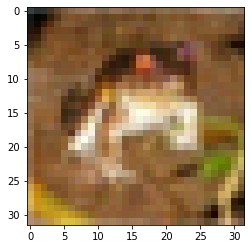

In [13]:
print("true val: ", egy)
print('predict raw', torch.argmax(model(eg),dim=1) )
for i in range(1):
    x_adv = eg + 0.01 * torch.randn(eg.shape).detach()
    x_adv = torch.clamp(x_adv, 0.0, 1.0)
    plt.imshow(x_adv[0].permute(1,2,0))
    logits = model(x_adv) 
    print('pred: ', torch.argmax(logits, dim=1), 'logit: ', logits)

true val:  tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3])
predict raw tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3])
pred:  tensor([6, 9, 9, 6, 1, 1, 2, 7, 8, 3]) logit:  tensor([[-1.3860, -2.3211,  0.2447,  1.6922,  2.0704,  2.0156,  2.5545,  0.4982,
         -2.5245, -2.8435],
        [-0.3442,  1.4713, -0.8060, -0.7783, -2.3277, -0.6491, -1.4650, -0.4863,
          0.8098,  4.5763],
        [ 2.1529, -1.6159,  0.1043, -0.7914, -0.6974, -2.0566, -1.6060,  0.0497,
          0.7069,  3.7542],
        [-1.4807, -1.8512,  1.2122,  0.8730,  2.6873,  0.7344,  3.5813, -0.7577,
         -2.4121, -2.5859],
        [ 1.8124,  6.2739, -2.0108, -2.4807, -1.2984, -2.4284, -2.3536, -1.1846,
          1.3245,  2.3465],
        [-2.1000,  4.7904, -1.2940, -0.3498, -0.6354, -0.4220,  0.5265, -0.4018,
         -1.7155,  1.6022],
        [-0.2266, -1.4189,  2.7299, -0.8322,  2.1212, -0.4165,  0.6327,  0.9515,
         -2.2392, -1.3013],
        [-2.6919, -3.0978, -0.0350,  0.5549,  3.3308,  1.4070, -0.3095,  6.0981,
 

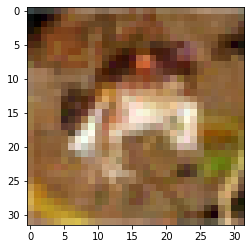

In [14]:
print("true val: ", egy)
print('predict raw', torch.argmax(model(eg),dim=1) )
for i in range(1):
    x_adv = pgd_attack(model, eg.clone(), egy.clone(), step_size=0.01, epsilon=8.0/255, perturb_steps=20)
    plt.imshow(x_adv[0].permute(1,2,0))
    logits = model(x_adv) 
    print('pred: ', torch.argmax(logits, dim=1), 'logit: ', logits)

In [9]:
model4 = get_model_for_attack('model4')

In [ ]:
logits4 = model4(x_adv) 
print('pred: ', torch.argmax(logits4, dim=1), 'logit: ', logits)

## Guessing the variance

In [10]:
import numpy as np

In [27]:
norm_n = []
norm_r6 = []
norm_r4 = []

model = model.cpu()
modeln = modeln.cpu()
model4 = model4.cpu()

trainset_org = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True,
        transform=transforms.ToTensor()
    )
loader_org = torch.utils.data.DataLoader(trainset_org, 50)

for i, (x, y) in tqdm(enumerate(loader_org)):
    logits_n = modeln(x)
    logits_r = model(x)
    logits_4 = model4(x)
    norm_n += [*logits_n.norm(dim=1).detach().numpy()]
    norm_r6 += [*logits_r.norm(dim=1).detach().numpy()]
    norm_r4 += [*logits_4.norm(dim=1).detach().numpy()]
    if (i == 30): break

Files already downloaded and verified


30it [01:37,  3.26s/it]


NameError: name 'norm_r' is not defined

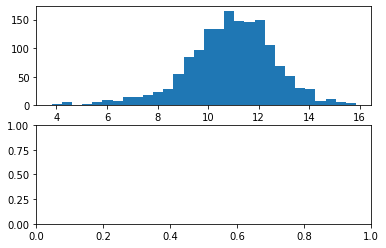

In [28]:
plt.subplot(2,1,1)
plt.hist(norm_n, bins=30)
plt.subplot(2,1,2)
plt.hist(norm_r, bins=30)

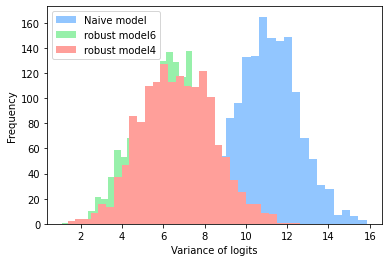

In [30]:
plt.style.use('seaborn-pastel')
plt.hist(norm_n, bins=30, label='Naive model')
plt.hist(norm_r6, bins=30, label='robust model6')
plt.hist(norm_r4, bins=30, label='robust model4')
plt.legend()
plt.xlabel('Variance of logits')
plt.ylabel('Frequency')
plt.savefig('variance.png')

In [32]:
loss_n = []
loss_r6 = []
loss_r4 = []

trainset_org = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True,
        transform=transforms.ToTensor()
    )
loader_org = torch.utils.data.DataLoader(trainset_org, 10)

for i, (x, y) in tqdm(enumerate(loader_org)):
    logits_n = nn.CrossEntropyLoss()(modeln(x),y)
    logits_r = nn.CrossEntropyLoss()(model(x),y)
    logits_4 = nn.CrossEntropyLoss()(model4(x),y)
    loss_n += [logits_n.detach().numpy()]
    loss_r6 += [logits_r.detach().numpy()]
    loss_r4 += [logits_4.detach().numpy()]
    if (i == 30): break

Files already downloaded and verified


30it [00:18,  1.58it/s]


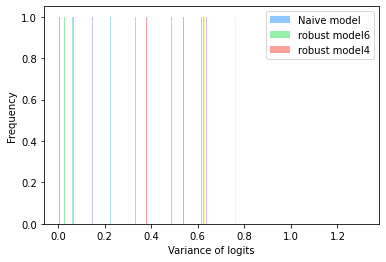

In [34]:
plt.style.use('seaborn-pastel')
plt.hist(loss_n, bins=30, label='Naive model')
plt.hist(loss_r6, bins=30, label='robust model6')
plt.hist(loss_r4, bins=30, label='robust model4')
plt.legend()
plt.xlabel('Variance of logits')
plt.ylabel('Frequency')
plt.savefig('variance.png')

In [ ]:
## Explore random space

In [48]:
loss_n = []
loss_r6 = []
loss_r4 = []

for i in tqdm(range(500)):
    x = eg + 0.01 * torch.randn(eg.shape).detach()
    x = torch.clamp(x, 0.0, 1.0)
    logits_n = nn.CrossEntropyLoss()(modeln(x),egy)
    logits_r = nn.CrossEntropyLoss()(model(x),egy)
    logits_4 = nn.CrossEntropyLoss()(model4(x),egy)
    loss_n += [logits_n.detach().numpy()]
    loss_r6 += [logits_r.detach().numpy()]
    loss_r4 += [logits_4.detach().numpy()]


100%|██████████| 500/500 [04:55<00:00,  1.69it/s]


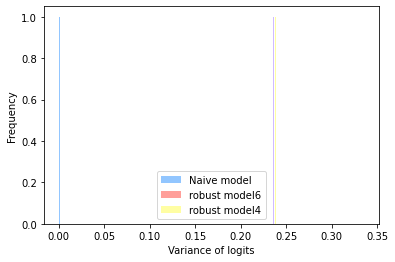

In [50]:
plt.style.use('seaborn-pastel')
plt.hist(loss_n,  label='Naive model')
plt.hist(loss_r6,  label='robust model6')
plt.hist(loss_r4,  label='robust model4')
plt.legend()
plt.xlabel('Variance of logits')
plt.ylabel('Frequency')
plt.savefig('variance.png')

## Fail

In [19]:
norm_adv_n = []
norm_adv_r = []
acc = 0 
racc = 0

trainset_org = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True,
        transform=transforms.ToTensor()
    )
loader_org = torch.utils.data.DataLoader(trainset_org, 256)

for i, (x, y) in tqdm(enumerate(loader_org)):
    x = x.cuda()
    y = y.cuda()
    modeln.cuda()
    model.cuda()
    x_adv = pgd_attack(model, x.clone(), y.clone(), step_size=0.01, epsilon=8.0/255, perturb_steps=20)
    logits_n = modeln(x_adv)
    logits_r = model(x_adv)
    norm_adv_n += [*logits_n.norm(dim=1).detach().cpu().numpy()]
    norm_adv_r += [*logits_r.norm(dim=1).detach().cpu().numpy()]
    acc += (torch.argmax(logits_n,dim=1) == y).sum()
    racc +=(torch.argmax(logits_r,dim=1) == y).sum()

Files already downloaded and verified


2073it [26:17,  1.31it/s]


KeyboardInterrupt: 

In [ ]:
print('acc= {}, racc= {}'.format(acc,racc))
plt.subplot(2,1,1)
plt.hist(norm_n, bins=30)
plt.subplot(2,1,2)
plt.hist(norm_r, bins=30)